# 从二进制文件中加载点云数据

KITTI 中的点云数据以 float32 格式存储，一个点 4 个数据，行优先顺序。可以使用 numpy 读入再 reshape

In [1]:
import numpy as np
points = np.fromfile('data/kitti/training/velodyne/000008.bin', dtype=np.float32)
# points = np.fromfile('data/kitti/training/velodyne_reduced/000008.bin', dtype=np.float32)
print(points.shape)

(490220,)


In [2]:
pts = points.reshape(-1,4)
print(pts.shape)

(122555, 4)


尝试绘制一下 BEV （激光雷达的 X 指向前方，Y 指向左侧）

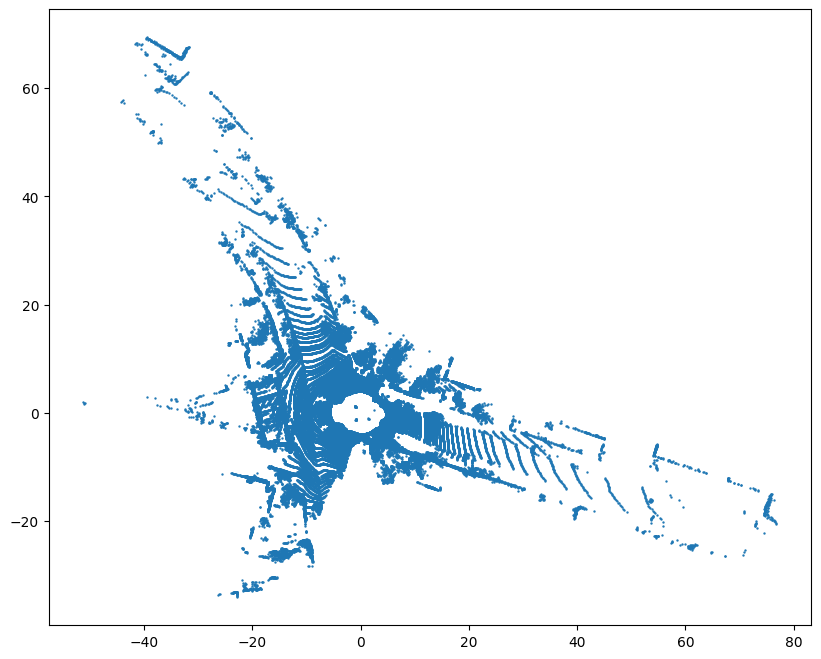

In [3]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(pts[:,0], pts[:,1], 0.5)
plt.axis('image')
plt.show()

# 基于 Open3D 绘制点云数据和标注框、坐标系变换

读入点云数据（截取FOV 90°内的点云）

In [4]:
import numpy as np
pts = np.fromfile('data/kitti/training/velodyne_reduced/000008.bin', dtype=np.float32).reshape(-1,4)

读入标注，每行的最后7个数字是标注框，为**相机坐标系下**的高、宽、长、X、Y、Z坐标、转角

In [5]:
bbxs = np.loadtxt('data/kitti/training/label_2/000008.txt', max_rows=6, usecols=range(8,15)).reshape(-1,7)

In [6]:
bbxs

array([[ 1.6 ,  1.57,  3.23, -2.7 ,  1.74,  3.68, -1.29],
       [ 1.57,  1.5 ,  3.68, -1.17,  1.65,  7.86,  1.9 ],
       [ 1.39,  1.44,  3.08,  3.81,  1.64,  6.15, -1.31],
       [ 1.47,  1.6 ,  3.66,  1.07,  1.55, 14.44, -1.25],
       [ 1.7 ,  1.63,  4.08,  7.24,  1.55, 33.2 ,  1.95],
       [ 1.59,  1.59,  2.47,  8.48,  1.75, 19.96, -1.25]])

错误示范，坐标系没有转换，相机坐标系的 Z 轴在激光雷达坐标系中是天上

In [7]:
from mmdet3d.core.visualizer.show_result import show_result
# Change order: 3D bbox (x, y, z, dx, dy, dz, yaw) to be visualized.
show_result(pts, bbxs[:, [3,4,5,0,1,2,6]], None, '.', '3-show', show=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]


坐标系变换，XYZ轴调换顺序，相机和雷达前后方向27cm偏移

In [8]:
R_velo_to_cam = np.array([[0, -1, 0],
                          [0, 0, -1],
                          [1, 0, 0]])
coors = bbxs[:, 3:6] @ R_velo_to_cam[:,:3] + [0.27, 0, 0]

MMDet3D 的雷达坐标系中，右对应yaw=-90，前对应yaw=0
KITTI中，右对应yaw=0，前对应yaw=-90
因此，`yaw_in_mmdet3d = -pi/2 - yaw_in_kitti `

In [9]:
yaw = -1.57 - bbxs[:, 6:7]

调用 mmdet3d 的 API 实现点云绘图

In [10]:
from mmdet3d.core.visualizer.show_result import show_result
show_result(pts, np.hstack((coors, bbxs[:, [2,1,0]], yaw)), None, '.', '3-show', show=True)

# MMDET3D 提供的可视化工具